In [1]:
import torch
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import pathlib
from torch.utils.data import Dataset, DataLoader
import os
import utils
import shutil 
from hand_landmarker import draw_landmarks_on_image, get_hand_landmarker, show
from tqdm import tqdm
from torchvision import transforms


IMAGE_DIR = "images/img2.jpeg"
IMAGE_BIGGER_DIR = "images/img2_bigger.jpeg"
DATASET_PATH = "asl_dataset/"
CROPPED_DATASET_PATH = "asl_dataset_cropped/"

2024-07-22 09:57:05.496847: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1721622442.038804 13202156 gl_context.cc:357] GL version: 2.1 (2.1 ATI-5.5.17), renderer: AMD Radeon Pro 5300M OpenGL Engine
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1721622442.257845 13206143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721622442.312128 13206143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


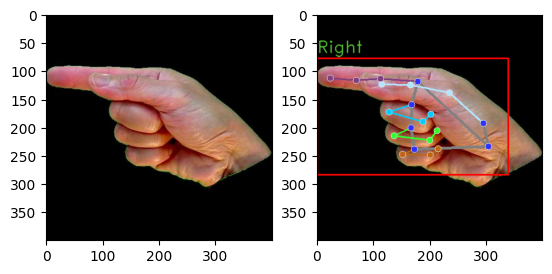

In [2]:
show(IMAGE_DIR)

In [3]:
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

I0000 00:00:1721622444.888602 13202156 gl_context.cc:357] GL version: 2.1 (2.1 ATI-5.5.17), renderer: AMD Radeon Pro 5300M OpenGL Engine
W0000 00:00:1721622444.907834 13206301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721622444.932900 13206301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [4]:
img = cv2.imread(IMAGE_DIR)
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = mp.Image.create_from_file(IMAGE_DIR)
detection_result = detector.detect(image)

In [5]:
draw_landmarks_on_image(img_RGB, detection_result)['all_coordinates']

[[(0.7591127157211304, 0.5867081880569458, 1.2910095392726362e-07),
  (0.7351135015487671, 0.48334941267967224, -0.12930862605571747),
  (0.5857406258583069, 0.3499625027179718, -0.158351868391037),
  (0.41450509428977966, 0.31407585740089417, -0.1661832481622696),
  (0.28647544980049133, 0.31003066897392273, -0.1560972034931183),
  (0.4451695382595062, 0.2977854311466217, -0.057365160435438156),
  (0.28002431988716125, 0.2854820489883423, -0.13684877753257751),
  (0.17404264211654663, 0.2929789423942566, -0.17225608229637146),
  (0.05836227536201477, 0.2830981910228729, -0.1918880045413971),
  (0.4191140830516815, 0.4022899270057678, -0.02618802711367607),
  (0.3195428252220154, 0.4345070421695709, -0.11433429270982742),
  (0.4692046642303467, 0.4762083888053894, -0.11115371435880661),
  (0.5035346746444702, 0.4425759017467499, -0.08422602713108063),
  (0.4165421724319458, 0.5032446980476379, -0.018444770947098732),
  (0.3406127393245697, 0.5398486852645874, -0.13534857332706451),
  (

In [162]:
# bigger = cv2.resize(img, (0, 0), fx=4, fy=4)
# cv2.imwrite(IMAGE_BIGGER_DIR, bigger)

In [163]:
# img = cv2.imread(IMAGE_BIGGER_DIR)
# img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# image = mp.Image.create_from_file(IMAGE_BIGGER_DIR)
# detection_result = detector.detect(image)

In [164]:
# draw_landmarks_on_image(img_RGB, detection_result)['all_coordinates']

In [6]:
images = list(pathlib.Path(DATASET_PATH).glob("*/*.jpeg"))
images[:5]

[PosixPath('asl_dataset/r/hand2_r_top_seg_2_cropped.jpeg'),
 PosixPath('asl_dataset/r/hand2_r_right_seg_1_cropped.jpeg'),
 PosixPath('asl_dataset/r/hand2_r_top_seg_5_cropped.jpeg'),
 PosixPath('asl_dataset/r/hand3_r_dif_seg_1_cropped.jpeg'),
 PosixPath('asl_dataset/r/hand2_r_bot_seg_3_cropped.jpeg')]

In [7]:
len(images)

2515

In [8]:
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

class ImageDataset(Dataset):
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.images_dirs = list(pathlib.Path(self.dataset_path).glob("*/*.jpeg"))


    def __len__(self):
        return len(self.images_dirs)

    def __getitem__(self, idx):
        path = self.images_dirs[idx]
        self.y = utils.label_to_num[os.path.dirname(path).split('/')[-1]]
        self.img = cv2.imread(str(path))
        self.img_RGB = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        image = mp.Image.create_from_file(str(path))
        detection_result = detector.detect(image)
        self.X = draw_landmarks_on_image(self.img_RGB, detection_result)['all_coordinates']
        
        self.y = torch.tensor(self.y)
        self.X = torch.tensor(self.X)
        return {"X": self.X, "y": self.y, "path": path}

I0000 00:00:1721622445.071093 13202156 gl_context.cc:357] GL version: 2.1 (2.1 ATI-5.5.17), renderer: AMD Radeon Pro 5300M OpenGL Engine
W0000 00:00:1721622445.090683 13206330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721622445.116540 13206333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [168]:
dataset = ImageDataset(DATASET_PATH)

In [169]:
dataset[1]["path"]

PosixPath('asl_dataset/r/hand2_r_right_seg_1_cropped.jpeg')

In [170]:
for data in tqdm(dataset):
    if torch.tensor(data['X']).numel() != 0:
        # Create subdirectory if it doesn't exist
        subdir = os.path.join(CROPPED_DATASET_PATH, utils.num_to_label[data['y'].item()])
        if not os.path.exists(subdir):
            os.makedirs(subdir)

        # Copy the image to the new folder
        dest_path = os.path.join(subdir, os.path.basename(data['path']))
        shutil.copy(data['path'], dest_path)
    else:
        # print(data)
        ctr += 1

print(ctr)

  0%|                                                                                                                  | 0/2515 [00:00<?, ?it/s]/var/folders/4j/xnkf0xg113jbh1s5hmzbf4lm0000gp/T/ipykernel_66076/3148176911.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if torch.tensor(data['X']).numel() != 0:
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2515/2515 [01:32<00:00, 27.19it/s]

2676


In [9]:
class ImageDataset2(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.images_dirs = list(pathlib.Path(self.dataset_path).glob("*/*.jpeg"))
        self.transform = transform

    def __len__(self):
        return len(self.images_dirs)

    def __getitem__(self, idx):
        path = self.images_dirs[idx]
        label = os.path.dirname(path).split('/')[-1]
        self.y = utils.label_to_num[label]
        self.img = cv2.imread(str(path))
        self.img_RGB = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        
        # Convert to PIL Image for transformations
        pil_image = Image.fromarray(self.img_RGB)
        
        if self.transform:
            pil_image = self.transform(pil_image)
        
        # Convert back to NumPy array if needed
        self.img_RGB = np.array(pil_image)
        
        image = mp.Image.create_from_file(str(path))
        detection_result = detector.detect(image)
        self.X = draw_landmarks_on_image(self.img_RGB, detection_result)['all_coordinates']

        self.y = torch.tensor(self.y)
        self.X = torch.tensor(self.X)
        return {"X": self.X, "y": self.y, "path": path}

In [10]:
dataset2 = ImageDataset2(CROPPED_DATASET_PATH)
len(dataset2)

6492

In [11]:
dataset2[500]

{'X': tensor([[[ 5.2745e-01,  9.0417e-01,  6.8769e-07],
          [ 6.4908e-01,  8.1276e-01, -6.7039e-02],
          [ 7.6342e-01,  6.5689e-01, -1.0168e-01],
          [ 7.9402e-01,  5.0564e-01, -1.3894e-01],
          [ 6.9960e-01,  4.2266e-01, -1.7094e-01],
          [ 6.3471e-01,  4.7526e-01, -2.9057e-02],
          [ 6.4336e-01,  3.2919e-01, -1.0864e-01],
          [ 6.6126e-01,  3.5961e-01, -1.6606e-01],
          [ 6.7021e-01,  4.3569e-01, -1.9007e-01],
          [ 5.2818e-01,  4.5208e-01, -3.5071e-02],
          [ 5.1785e-01,  2.6196e-01, -6.6547e-02],
          [ 5.1390e-01,  1.4759e-01, -9.2745e-02],
          [ 5.1397e-01,  4.3788e-02, -1.0942e-01],
          [ 4.4159e-01,  4.7474e-01, -5.7712e-02],
          [ 3.9449e-01,  3.1104e-01, -8.9940e-02],
          [ 3.7327e-01,  2.0176e-01, -1.0611e-01],
          [ 3.5617e-01,  1.1327e-01, -1.1531e-01],
          [ 3.5605e-01,  5.3525e-01, -9.0717e-02],
          [ 2.7905e-01,  4.2756e-01, -1.1611e-01],
          [ 2.3130e-01,  3

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6492/6492 [04:27<00:00, 24.31it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6492,) + inhomogeneous part.